In [1]:
using DataFrames
using Gadfly
using Chemfiles
set_default_plot_size(30cm, 12cm)
home = "/home/german/labo/18/lbp/run"
rtdos = "/home/german/labo/18/lbp/rtdos_log"

"/home/german/labo/18/lbp/rtdos_log"

In [2]:
# Agarra una matriz de PCA en Calpha de 3Nx3N-6 y devuelve
# una lista de 3N-6 matrices, c/u de 3x3N. C/ mtx es 1 modo reordenado
# p/ matchear las matrices de coordenadas de carbonos alfa
function format_pca_aa(in_mtx::Array{Float64, 2})
    v_length = size(in_mtx)[1]
    v_nbr = size(in_mtx)[2]

    aa = Int64
    try
        aa = convert(Int64, v_length / 3)
    catch
        error("Vector length: ", v_length, " is not divisible by 3.")
    end

    list_out_mtx = Array{Array{Float64, 2}, 1}(v_nbr);
    for j = 1:v_nbr
        list_out_mtx[j] = reshape(in_mtx[:, j], 3, aa)
    end

    return list_out_mtx
end


# Agarra la topología una matriz de PCA en Calpha de 3Nx3N-6 y devuelve
# una lista de 3N-6 matrices, c/u de 3xNatomos. C/ mtx es 1 modo reordenado
# p/ matchear las matrices de coordenadas del pdb q dió lugar a la topología.

# También devuelve un array con el nro de atomos q tiene c/ aa
function format_pca_atom(in_top::Topology, in_mtx::Array{Float64, 2}, mask::Array{Float64, 1} = 0)
    # Preparo variables
    aa = Int64
    aa_3 = Int64
    if mask == 0 
        aa = convert(Int64, count_residues(in_top))
    else
        aa = length(mask)
    end
    aa_3 = aa * 3
    
    v_length = size(in_mtx)[1]
    v_nbr = size(in_mtx)[2]
    if v_length != aa_3
        error("Input vector with wrong dimensions: ", v_length, "  ", (aa_3, 1))
    end

    # Determino orden de residuos (hay q actualizar el Julia Chemfiles)
    tmp = Array{Int64}(aa)
    ids = Array{Int64}(aa)
    [ ids[i+1] = convert(Int64, id((Residue(in_top, i)))) for i = 0:aa-1 ]
    idx = sortperm(ids)
    # Determino el nro de atomos de c/ aminoácido. Resto 1 pq Chemfiles tiene 0-indexing
    [ tmp[i] = size(Residue(in_top, mask[i] - 1)) for i = 1:aa ]
    natom_aa = tmp[idx]
    natoms = sum(natom_aa)

    # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    list_out_mtx = Array{Array{Float64, 2}, 1}(v_nbr);
    
    for j in 1:v_nbr
        vector = reshape(in_mtx[:, j], 3, aa)
        list_out_mtx[j] = Array{Float64}(3, natoms)
        cursor = 0
        for i = 1:aa
            rango = Array{Int64}(natom_aa[i])
            if i == 1
                list_out_mtx[j][:, 1:natom_aa[i]] = repmat(vector[:, i], 1, natom_aa[i])
                cursor = natom_aa[i]
                continue
            end
            rango = collect(cursor+1:cursor + natom_aa[i])
            list_out_mtx[j][:, rango] = repmat(vector[:, i], 1, natom_aa[i])
            cursor += natom_aa[i]
        end
    end

    return list_out_mtx, natom_aa
end

format_pca_atom (generic function with 2 methods)

In [3]:
function get_κ(in_vec::Array{Float64, 1})
    not_null = copy(in_vec)
    not_null[not_null .== 0] = 0.000001
    const κ = (exp.(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log.(x.^2), not_null, 1), 1))
        / length(not_null))[1]
    return κ
end

function get_pnum(in_vec::Array{Float64, 1})
    nor_vec = in_vec ./ norm(in_vec) 
    return convert(Int64, round(sum(nor_vec .^ 4) .^ -1))
end

function tognm(vtor_anm)
    vtor_gnm = Array{Float64}
    try
        vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    catch e
        warn("Input vector's length is not a 3 multiplier")
        error(e)
    end
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

function MatHisInd2D(in_vec_x::AbstractArray, in_vec_y::AbstractArray,
    in_bins_x::AbstractArray, in_bins_y::AbstractArray,
    include_bounds = true)

    const cnt = length(in_vec_x)
    if  length(in_vec_y) != cnt
        error("Input vectors length don't match. X: ", in_vec_x, " Y: ", in_vec_y)
    end
         
    const n_x = length(in_bins_x)
    const n_y = length(in_bins_y)
    
    his_ind = [Int[] for i=1:n_x, j=1:n_y]
    his = zeros(Int64, n_x, n_y)
    if include_bounds
        for i in 1:cnt
            x = searchsortedfirst(in_bins_x, in_vec_x[i])
            y = searchsortedfirst(in_bins_y, in_vec_y[i])
            if x > n_x
                x = n_x
            end
            if y > n_y
                y = n_y
            end
            
            push!(his_ind[x, y], i)
            his[x, y] += 1
        end
    else
        for i in 1:cnt
            const x = searchsortedfirst(in_bins_x, in_vec_x[i])
            const y = searchsortedfirst(in_bins_y, in_vec_y[i])
        
            if x > n_x || y > n_y
                continue
            end
            if (x == 1 && isless(x, in_vec_x[x])) || (y == 1 && isless(y, in_vec_y[y]))
                continue
            end

            push!(his_ind[x, y], i)
            his[x, y] += 1
        end
    end
    
    return his_ind, his
end

function read_ptraj_modes(filename, nmodes::Int64=0, norma::Bool=true)
    modes_text = readdlm(filename, skipstart=0, skipblanks=true, comments=true,
        comment_char='\*')

    if nmodes == 0
        nmodes = modes_text[1, 5]
    end
    modes_elements = modes_text[2, 1]

    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)

    eval = Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1 = Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header
    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = permutedims(modes_text[(j+1):(lines+j), :], [2, 1])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
        mode[:, i] = temp2
        j = j + lines + 1
    end

    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end

    return mode, eval
end

function energia_gdte(evals::Array{Float64, 1}, gdte::Array{Float64, 1}, d::Float64 = 1.)

    if length(evals) != length(gdte)
        error("Lengths of evals and gdte don't match. Aborting.") 
    end
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    const k = 1.38064852e-23
    const avgdro = 6.0221409e+23
    const T = 298
    const RT =  k * avgdro * T * 1E-3 * 0.239006 # Kcal/mol
    const cte = 11792.08316093831
    
    return d^2 * 0.5 * RT * sum(evals.^2 .* gdte.^2) / cte # Kcal/mol
end

function WeightedHist(in_vec, in_bins, in_weight, density = true, include_bounds = true)
    # Safety check    
    if length(in_vec) != length(in_weight)
        error("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    const n_x = length(in_bins)
    out_counts = zeros(n_x-1)
    
    if include_bounds
        for i in 1:length(in_vec)
            x = searchsortedfirst(in_bins, in_vec[i])
            
            if x >= n_x
                x = n_x - 1
            end
            
            out_counts[x] += in_weight[i]
        end
    else
        for i in 1:length(in_vec)
            const x = searchsortedfirst(in_bins, in_vec[i])
            
            if x >= n_x
                continue
            elseif x == 1 && isless(in_bins[x], in_vec[i])
                continue
            end

            out_counts[x] += in_weight[i]
        end
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    
    return out_counts, out_middle
end

WeightedHist (generic function with 3 methods)

In [8]:
pdb = "4xcp"
# Leo modos
modes_lig, evals_lig = read_ptraj_modes(
    joinpath(home, pdb, "lig" ,"pca", string("full_modes_lig_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_4xcp))
aa = convert(Int64, aa3 / 3)

133

In [22]:
# Get avg ready
in_avg_trj = Trajectory(joinpath(home, pdb, "lig", "pca", string("full_avg_lig_", pdb, ".pdb")))
in_avg_frm = read(in_avg_trj)
in_avg_top = Topology(in_avg_frm)

# Estas son las coordenadas q voy a usar p/ restar
lig_atoms = 2427:2444
avg_lig_xyz = positions(in_avg_frm)[:, lig_atoms];
natoms_lig = 2444 - 2427 + 1
natoms_lig_3 = natoms_lig * 3

54

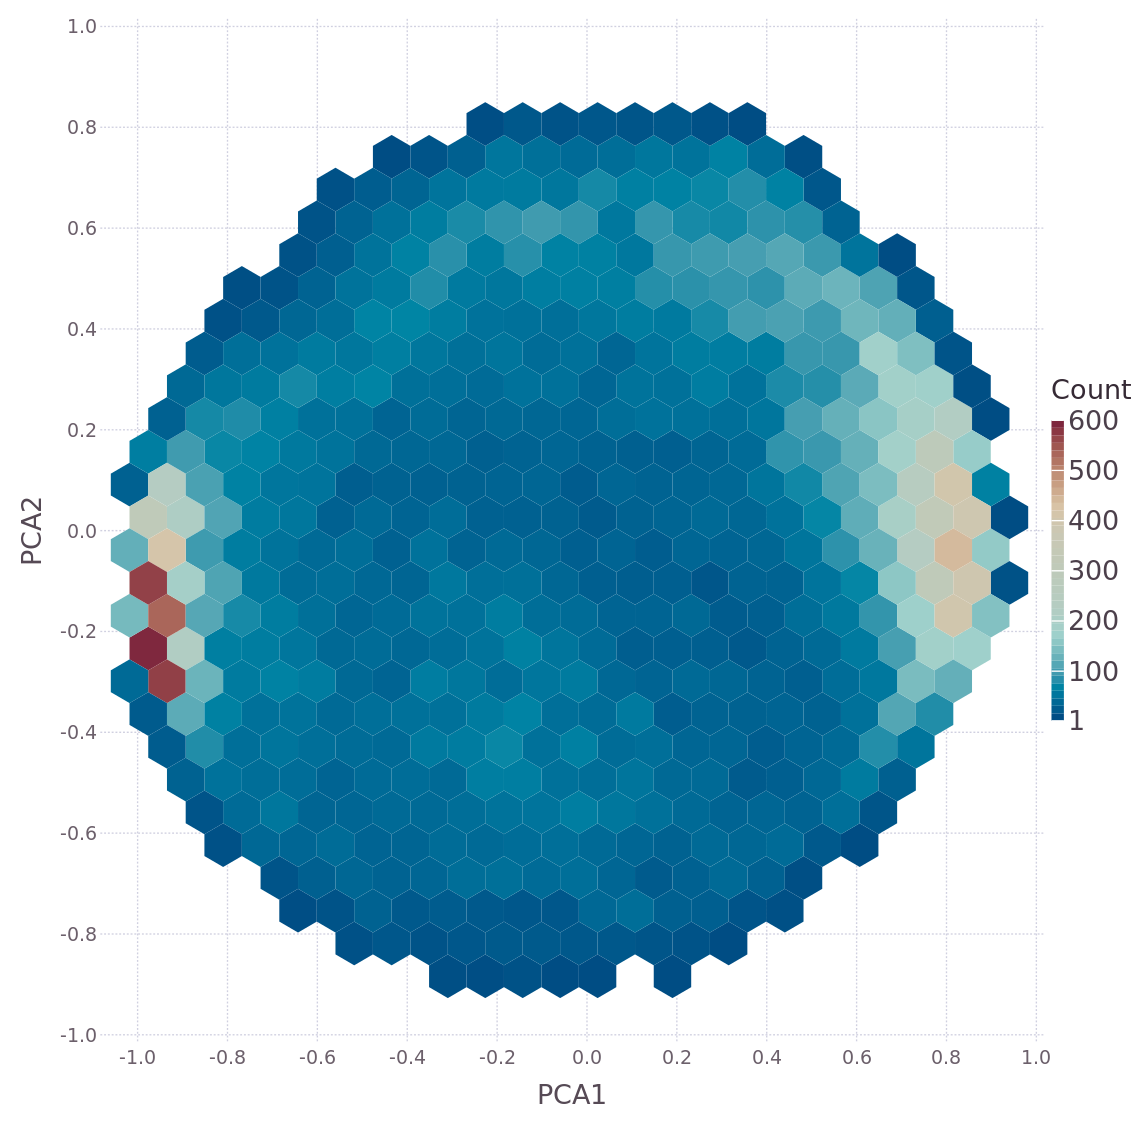

In [30]:
set_default_plot_size(30cm, 30cm)
plot(df_smooth_prj_lig, x = "PCA1", y = "PCA2",
    #color = "Time",
    Geom.hexbin(xbincount = 40, ybincount = 40),
    #Geom.smooth(method=:loess,smoothing=0.001),
    #Guide.title("Cut"),

    #Coord.cartesian(xmin = -1., xmax = 1., ymin = -1., ymax = 1.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    Guide.xticks(ticks=collect(-1:.2:1)),
    Guide.yticks(ticks=collect(-1:.2:1)),
    
    #Scale.color_continuous(colormap=Scale.lab_gradient("#f2f2f2", "Indigo", "DarkMagenta", "Black")),
    #Scale.color_continuous(minvalue = 100, maxvalue = 1000),
    #Scale.x_continuous(minvalue = 200),
    #Scale.y_continuous(minvalue = 200),
    
    Theme(bar_spacing=2pt, grid_line_width = 1pt, line_width = 2pt, point_size = 0.75pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

In [32]:
set_default_plot_size(30cm, 12cm)

## Separo las poblaciones según PCA

In [ ]:
idx_lig_0 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_lig0")))[:, 1])
idx_lig_0 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_lig1")))[:, 1])
# Leo volumen
trj_vol = convert(Array{Float64, 1}, readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);

# Estiro el volumen 
full_trj_vol = Array{Float64}(length(trj_vol)*10)
for i = 1:length(trj_vol)
    k = (i-1) * 10 + 1
    full_trj_vol[k:k+9] =  fill(trj_vol[i], 10)
end

trj_vol0 = full_trj_vol[idx_lig_0]
trj_vol1 = full_trj_vol[idx_lig_0]

In [52]:
# Leo volumen
trj_vol = convert(Array{Float64, 1}, readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);
# Estiro el volumen 
full_trj_vol = Array{Float64}(length(trj_vol)*10)
for i = 1:length(trj_vol)
    k = (i-1) * 10 + 1
    full_trj_vol[k:k+9] =  fill(trj_vol[i], 10)
end

trj_vol0 = full_trj_vol[idx_lig_0]
trj_vol1 = full_trj_vol[idx_lig_1];

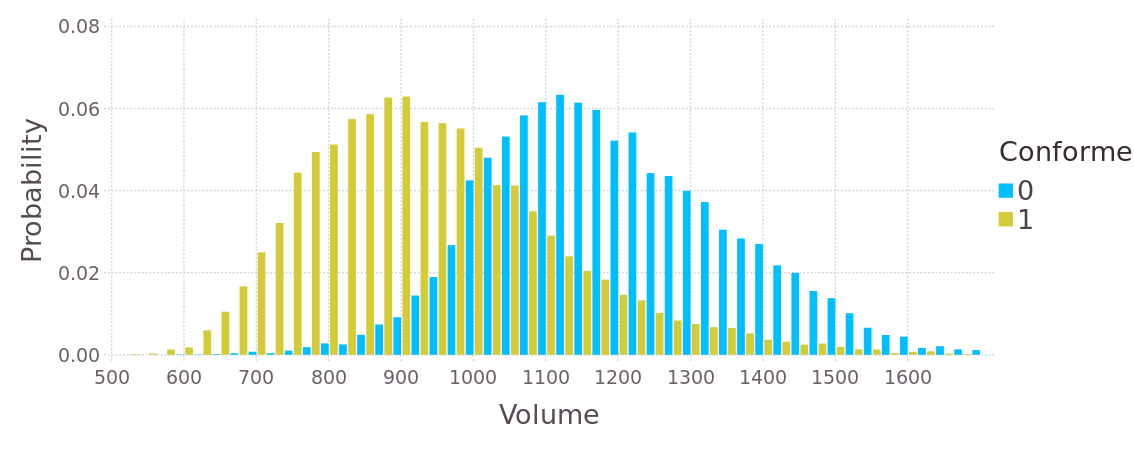

In [60]:
bin_lig = collect(400:25:1700)

# Histograma ponderado
wgh_lig = fill(1.0, length(trj_vol0))
his_lig0_4xcp, bin_lig0_4xcp = WeightedHist(trj_vol0, bin_lig, wgh_lig, true, false);
wgh_lig = fill(1.0, length(trj_vol1))
his_lig1_4xcp, bin_lig1_4xcp = WeightedHist(trj_vol1, bin_lig, wgh_lig, true, false);

df_Whis_lig_str = DataFrame(Probability = [ his_lig0_4xcp ; his_lig1_4xcp ],
    Volume = [ bin_lig0_4xcp ; bin_lig1_4xcp ],
    Conformer = [ fill("0", length(his_lig0_4xcp)) ;
        fill("1", length(his_lig1_4xcp)) ]);

plot(df_Whis_lig_str, x = "Volume", y = "Probability", color = "Conformer",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),
    Coord.cartesian(xmin = 500, xmax = 1710),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    Guide.xticks(ticks = collect(500:100:1600)),

    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

In [61]:
df_datos = DataFrame(MEAN = [ mean(trj_vol0) ; mean(trj_vol1) ],
    STD = [ std(trj_vol0) ; std(trj_vol1) ])

,MEAN,STD
1,1151.3477949849225,167.84552855645845
2,931.0373479584657,174.44326524958944


## Comparo con los índices separados por proteína

In [77]:
idx_prt0 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb,"_idx_vol0")))[:, 1])
idx_prt1 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb,"_idx_vol1")))[:, 1])
idx_prt2 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb,"_idx_vol2")))[:, 1]);
# Junto
idx_prt12 = [ idx_prt1 ; idx_prt2 ];

trj_vol_prt0 = full_trj_vol[idx_prt0]
trj_vol_prt1 = full_trj_vol[idx_prt1]
trj_vol_prt2 = full_trj_vol[idx_prt2]
trj_vol_prt12 = full_trj_vol[idx_prt12];

In [78]:
wgh_lig = fill(1.0, length(trj_vol_prt0))
his_vol_prt0, bin_vol_prt0 = WeightedHist(trj_vol_prt0, bin_lig, wgh_lig, true, false);

wgh_lig = fill(1.0, length(trj_vol_prt1))
his_vol_prt1, bin_vol_prt1 = WeightedHist(trj_vol_prt1, bin_lig, wgh_lig, true, false);

wgh_lig = fill(1.0, length(trj_vol_prt2))
his_vol_prt2, bin_vol_prt2 = WeightedHist(trj_vol_prt2, bin_lig, wgh_lig, true, false);

wgh_lig = fill(1.0, length(trj_vol_prt12))
his_vol_prt12, bin_vol_prt12 = WeightedHist(trj_vol_prt12, bin_lig, wgh_lig, true, false);

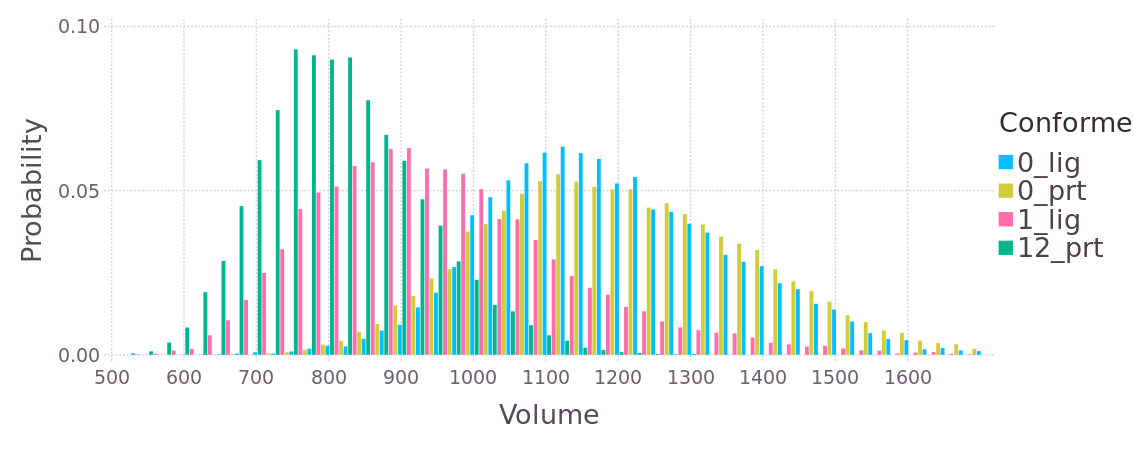

In [76]:
df_his_both = DataFrame(Probability =
    [ his_lig0_4xcp ; his_vol_prt0 ; his_lig1_4xcp ; his_vol_prt12 ],
    Volume = [ bin_lig0_4xcp ; bin_vol_prt0 ; bin_lig1_4xcp ; bin_vol_prt12 ],
    Conformer = [ fill("0_lig", length(his_lig0_4xcp)) ; fill("0_prt", length(his_vol_prt0))
        fill("1_lig", length(his_lig1_4xcp)) ; fill("12_prt", length(his_vol_prt12)) ]);

plot(df_his_both, x = "Volume", y = "Probability", color = "Conformer",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),
    Coord.cartesian(xmin = 500, xmax = 1710),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    Guide.xticks(ticks = collect(500:100:1600)),

    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

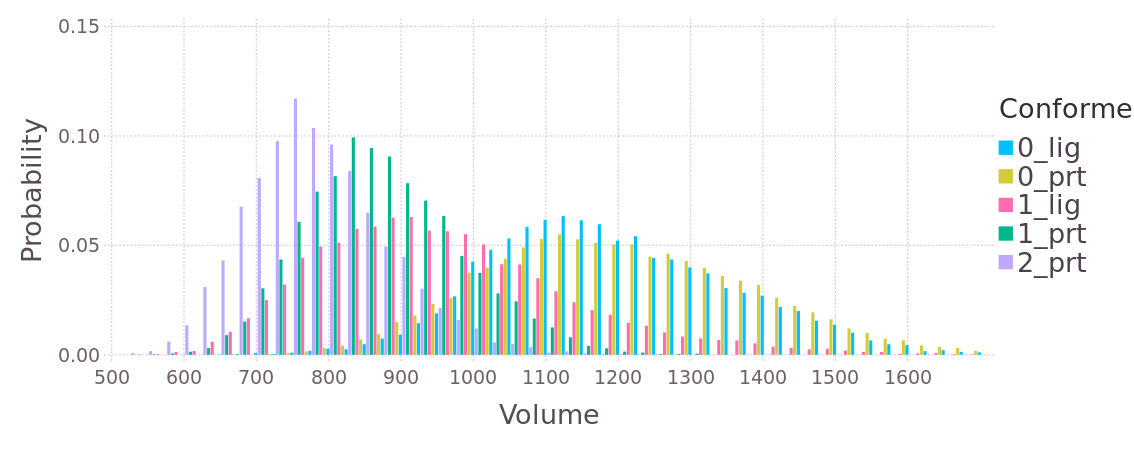

In [81]:
df_his_both = DataFrame(Probability =
    [ his_lig0_4xcp ; his_vol_prt0 ; his_lig1_4xcp ; his_vol_prt1 ; his_vol_prt2 ],
    Volume = [ bin_lig0_4xcp ; bin_vol_prt0 ; bin_lig1_4xcp ; bin_vol_prt1 ; bin_vol_prt2 ],
    Conformer = [ fill("0_lig", length(his_lig0_4xcp)) ; fill("0_prt", length(his_vol_prt0)) ;
        fill("1_lig", length(his_lig1_4xcp)) ; fill("1_prt", length(his_vol_prt1)) ;
        fill("2_prt", length(his_vol_prt2))]);

plot(df_his_both, x = "Volume", y = "Probability", color = "Conformer",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),
    Coord.cartesian(xmin = 500, xmax = 1710),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    Guide.xticks(ticks = collect(500:100:1600)),

    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

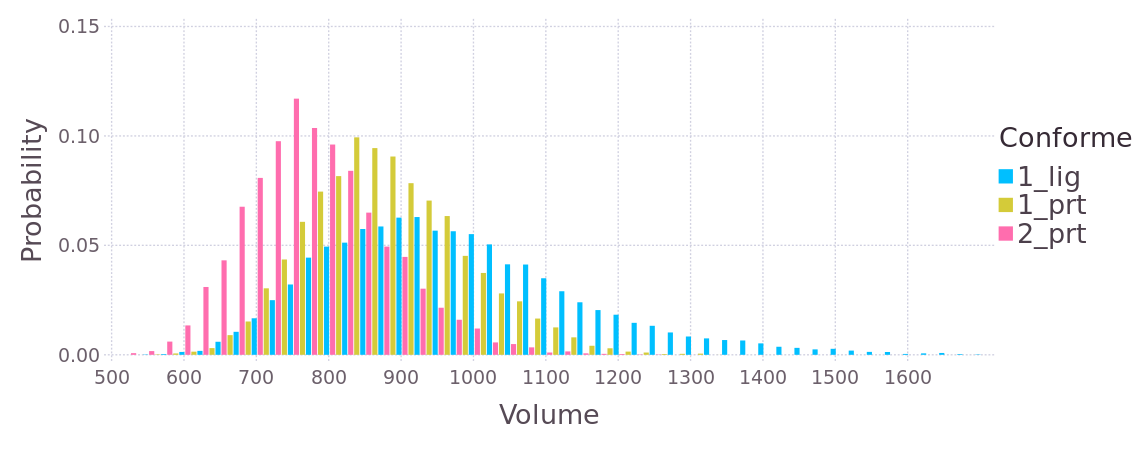

In [82]:
df_his_both = DataFrame(Probability =
    [ his_lig1_4xcp ; his_vol_prt1 ; his_vol_prt2 ],
    Volume = [ bin_lig1_4xcp ; bin_vol_prt1 ; bin_vol_prt2 ],
    Conformer = [ fill("1_lig", length(his_lig1_4xcp)) ; fill("1_prt", length(his_vol_prt1)) ;
        fill("2_prt", length(his_vol_prt2))]);

plot(df_his_both, x = "Volume", y = "Probability", color = "Conformer",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),
    Coord.cartesian(xmin = 500, xmax = 1710),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    Guide.xticks(ticks = collect(500:100:1600)),

    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

# Poblaciones

#### Leo el RMSD respecto al avg

In [103]:
rmsd_lig0 = readdlm(joinpath(home, pdb, "lig", "poblaciones", "intra", string("rmsd_lig0")))[:, 2]
rmsd_lig1 = readdlm(joinpath(home, pdb, "lig", "poblaciones", "intra", string("rmsd_lig1")))[:, 2];

In [97]:
#### Guardo el frame más similar al avg

In [104]:
# 0
trj_in = Trajectory(joinpath(home, pdb, "lig", "poblaciones", string("lig0_", pdb, ".nc")))
in_top_trj = Trajectory(joinpath(home, pdb, "lig", "poblaciones", "intra", string("avg_lig0_", pdb, ".pdb")))
in_top_frm = read(in_top_trj)
in_top = Topology(in_top_frm)
in_frm = read_step(trj_in, indmin(rmsd_lig0) - 1)
set_topology!(in_frm, in_top)
trj_out = Trajectory(joinpath(home, pdb, "lig", "poblaciones", "intra", string("top_lig0_", pdb, ".pdb")), 'w')
write(trj_out, in_frm)
close(trj_out)
close(trj_in)

# 1
trj_in = Trajectory(joinpath(home, pdb, "lig", "poblaciones", string("lig1_", pdb, ".nc")))
in_top_trj = Trajectory(joinpath(home, pdb, "lig", "poblaciones", "intra", string("avg_lig1_", pdb, ".pdb")))
in_top_frm = read(in_top_trj)
in_top = Topology(in_top_frm)
in_frm = read_step(trj_in, indmin(rmsd_lig1) - 1)
set_topology!(in_frm, in_top)
trj_out = Trajectory(joinpath(home, pdb, "lig", "poblaciones", "intra", string("top_lig1_", pdb, ".pdb")), 'w')
write(trj_out, in_frm)
close(trj_out)
close(trj_in)

#### RMSD
#### intra

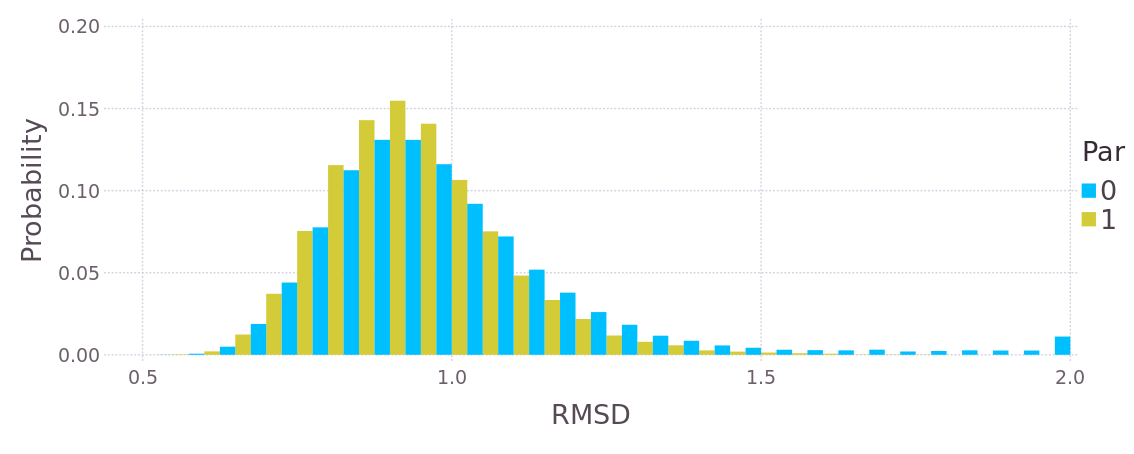

In [106]:
bin_rms = collect(0.5:.05:2.)

# Histograma ponderado
his_0, bin_0 = WeightedHist(rmsd_lig0, bin_rms, fill(1., length(rmsd_lig0)), true);
his_1, bin_1 = WeightedHist(rmsd_lig1, bin_rms, fill(1., length(rmsd_lig1)), true);

df_his_rms = DataFrame(Probability = [ his_0 ; his_1 ],
    RMSD = [ bin_0 ; bin_1 ],
    Par = [ fill("0", length(his_0)) ;
        fill("1", length(his_1)) ]);

plot(df_his_rms, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    Coord.cartesian(xmin = .45, xmax = 2.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

#### RMSD
#### inter

In [122]:
### Volume 0 vs Volume 1
proto_rmsd_0_1 = readdlm(joinpath(home, pdb, "lig", "poblaciones", "inter", "rms2_0_1_4xcp"))[:, 2:end]
rmsd_0_1 = reshape(proto_rmsd_0_1, length(proto_rmsd_0_1));

In [129]:
# Histograma ponderado
bin_rms = collect(.5:.05:4.)
his_0_1, bin_0_1 = WeightedHist(rmsd_0_1, bin_rms, fill(1., length(rmsd_0_1)), true);

df_his_rms = DataFrame(Probability = his_0_1, RMSD = bin_0_1,
    Par = fill("0_1", length(his_0_1)));

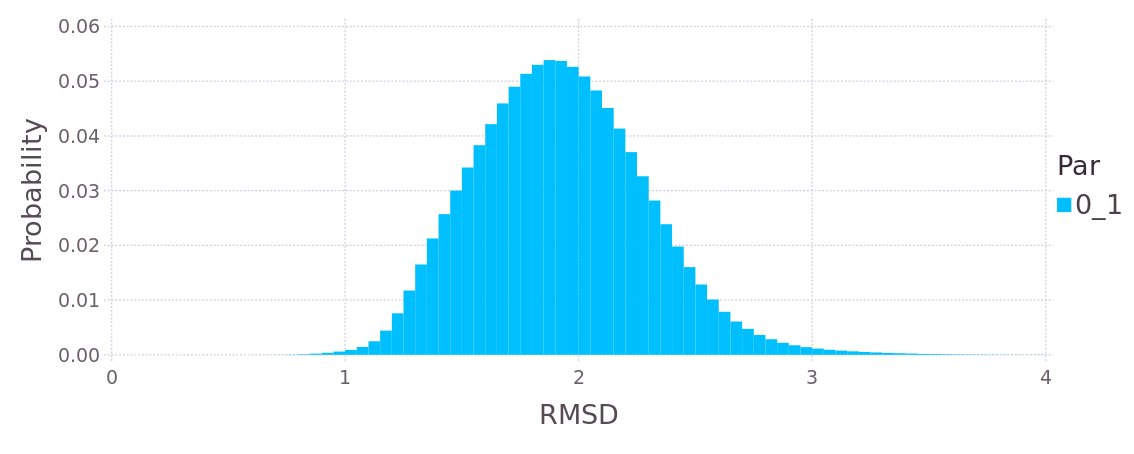

In [130]:
plot(df_his_rms, x = "RMSD", y = "Probability", color = "Par",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),

    #Coord.cartesian(xmin = 5., xmax = 32.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks=collect(-1:.2:1)),
    #Guide.yticks(ticks=collect(-1:.2:1)),
    
    Theme(bar_spacing=0pt, grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))